# Predicting homo-lumo gap using g4mp2-gdb9 database

## Download the database
Refererences: 
1. mdf documentation: https://mdf-forge.readthedocs.io/en/master/index.html
2. Database link: https://petreldata.net/mdf/detail/narayananbadri_g4mp2gdb9_database_v1.1/

In [ ]:
from mdf_forge.forge import Forge

In [ ]:
mdf = Forge()
mdf.match_source_names('narayananbadri_g4mp2gdb9_database')
res = mdf.search()

In [ ]:
res[0]

In [ ]:
mdf.get_globus(res, dest = '../data/', download_datasets = True)

## Load data from .db file

- download all tables from the database (`keys`, `number_key_values`, `species`, `systems`, `text_key_values`). 
- note: not necessary to do so since we only need `systems` for now.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import json

In [2]:
# change this to your file path
PATH = '../data/narayananbadri_g4mp2gdb9_database_v1.1/data/g4mp2-gdb9.db'
conn = sqlite3.connect(PATH)

In [3]:
# load each table in to data dictionary
raw_data = {}
for table_name in ['keys', 'number_key_values', 'species', 'systems', 'text_key_values']:
    raw_data[table_name] = pd.read_sql_query(f'SELECT * from {table_name}', conn)
conn.close()

In [4]:
# how many unique ids are there
n = len(set(raw_data['keys']['id']))
n

133296

In [5]:
# null entries check
for table_name in raw_data:
    print(f'{table_name}')
    print(raw_data[table_name].isnull().sum())
    print('---------------------------------')

keys
key    0
id     0
dtype: int64
---------------------------------
number_key_values
key      0
value    0
id       0
dtype: int64
---------------------------------
species
Z     0
n     0
id    0
dtype: int64
---------------------------------
systems
id                            0
unique_id                     0
ctime                         0
mtime                         0
username                      0
numbers                       0
positions                     0
cell                          0
pbc                           0
initial_magmoms          133296
initial_charges          133296
masses                   133296
tags                     133296
momenta                  133296
constraints              133296
calculator               133296
calculator_parameters    133296
energy                   133296
free_energy              133296
forces                   133296
stress                   133296
dipole                   133296
magmoms                  133296
magmom   

## Load key_value_pairs table

We are loading `key_value_pairs` table inside the `systems` data. It contains our smiles representation and some g4mp2 values of each molecules.

In [6]:
dfs = []
for i in range(5000):
    df = raw_data['systems']['key_value_pairs'][i]
    dfs.append(pd.DataFrame(json.loads(df), index = [0]))
    
kv_pairs = pd.concat(dfs).reset_index(drop = True)

In [7]:
kv_pairs.head()

,g4mp2_Standard_Enthalpy_Formation,g4mp2_Enthalpy,Smiles,Plain_InChI,g4mp2_ZPE,g4mp2_FreeE,g4mp2_AtomizationE,Plain_Smiles,g4mp2_E0K,g4mp2_Energy,InChI,gdbID
0,35.191660,-437.311525,O[C@H]1[C@H]2[C@H]3O[C@H]4[C@@H]1N2[C@@H]34,InChI=1S/C6H7NO2/c8-4-1-5-3-6(9-5)2(4)7(1)3/h1...,0.125447,-437.348073,1569.140848,OC1C2C3OC4C1N2C34,-437.318254,-437.312469,InChI=1S/C6H7NO2/c8-4-1-5-3-6(9-5)2(4)7(1)3/h1...,79782
1,103.123826,-373.267434,[NH][C]1N=CC=NC=N1,"InChI=1S/C4H4N4/c5-4-7-2-1-6-3-8-4/h1-3,5H",0.084785,-373.304676,1228.659484,N=C1N=CC=NC=N1,-373.274483,-373.268379,"InChI=1S/C4H4N4/c5-4-7-2-1-6-3-8-4/h1-3,5H",5049
2,10.408706,-385.423348,C[C@@]12C[C@H]3C[C@@H]1C(=O)[C@@H]23,InChI=1S/C8H10O/c1-8-3-4-2-5(8)7(9)6(4)8/h4-6H...,0.158545,-385.463053,1916.790874,CC12CC3CC1C(=O)C23,-385.431650,-385.424293,InChI=1S/C8H10O/c1-8-3-4-2-5(8)7(9)6(4)8/h4-6H...,72010
3,52.787736,-448.442482,Nc1n[nH]c2c1ocn2,"InChI=1S/C4H4N4O/c5-3-2-4(8-7-3)6-1-9-2/h1H,(H...",0.091877,-448.481342,1337.413069,NC1=NNC2=C1OC=N2,-448.450276,-448.443426,"InChI=1S/C4H4N4O/c5-3-2-4(8-7-3)6-1-9-2/h1H,(H...",130188
4,80.860120,-342.342341,N#C[C@H]1N[C@H]1C1CC1,"InChI=1S/C6H8N2/c7-3-5-6(8-5)4-1-2-4/h4-6,8H,1...",0.129373,-342.383555,1570.864615,N#CC1NC1C1CC1,-342.350954,-342.343285,"InChI=1S/C6H8N2/c7-3-5-6(8-5)4-1-2-4/h4-6,8H,1...",19995


## Generate MACCS key

- using python's RDKit package to generate MACCS key, the molecular fingerprint, of each particular molecule.
- MACCS key is 166 bits long.

In [8]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [9]:
maccs_fp = []
for smile in kv_pairs['Plain_Smiles']:
    mol = Chem.MolFromSmiles(smile)
    fp = MACCSkeys.GenMACCSKeys(mol)
    fp = fp.ToBitString()
    maccs_fp.append(fp)

In [141]:
maccs = pd.DataFrame()
maccs['smile'] = kv_pairs['Plain_Smiles']
for i in range(167):
    vals = [int(fp[i]) for fp in maccs_fp]
    if i != 0:
        maccs[f'maccs_{i}'] = vals
maccs['atomization_e'] = kv_pairs['g4mp2_AtomizationE']

In [142]:
maccs.head()

,smile,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,atomization_e
0,OC1C2C3OC4C1N2C34,0,0,0,0,0,0,0,1,0,...,1,1,0,1,0,1,1,1,0,1569.140848
1,N=C1N=CC=NC=N1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1228.659484
2,CC12CC3CC1C(=O)C23,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,1916.790874
3,NC1=NNC2=C1OC=N2,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,1,1,0,1337.413069
4,N#CC1NC1C1CC1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1570.864615


## Load homo-lumo data

- data can be found here: https://github.com/globus-labs/solvation-energy-ml/blob/master/data/output/g4mp2_data.json.gz

In [12]:
energy = []
with open('../data/g4mp2_data.json', 'r') as f:
    for line in f:
        vals = json.loads(line)
        if len(maccs[maccs['smile'] == vals['smiles_0']]) == 0:
            continue
        energy.append(pd.DataFrame({
            'smile': vals['smiles_0'],
            'homo': vals['homo'],
            'lumo': vals['lumo']
        }, index = [0]))
energy = pd.concat(energy)

In [13]:
energy.head()

,smile,homo,lumo
0,CC(C)(C)O,-0.2601,0.0664
0,CC1CC1C,-0.2632,0.0940
0,CC#CC=O,-0.2642,-0.0592
0,OCCC=O,-0.2536,-0.0285
0,CCCCO,-0.2615,0.0813


## Combine data

In [143]:
data = maccs.set_index('smile').join(energy.set_index('smile'))
data = data.dropna()

In [144]:
data.head()

,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,...,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,atomization_e,homo,lumo
smile,,,,,,,,,,,,,,,,,,,,,
OC1C2C3OC4C1N2C34,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,1,1,0,1569.140848,-0.2348,0.0213
N=C1N=CC=NC=N1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1228.659484,-0.2581,-0.1055
CC12CC3CC1C(=O)C23,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,1916.790874,-0.2313,-0.0027
NC1=NNC2=C1OC=N2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1337.413069,-0.2113,-0.0155
N#CC1NC1C1CC1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1570.864615,-0.2697,0.0167


In [145]:
data.to_csv('../data/maccs_data.csv')

## Features

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

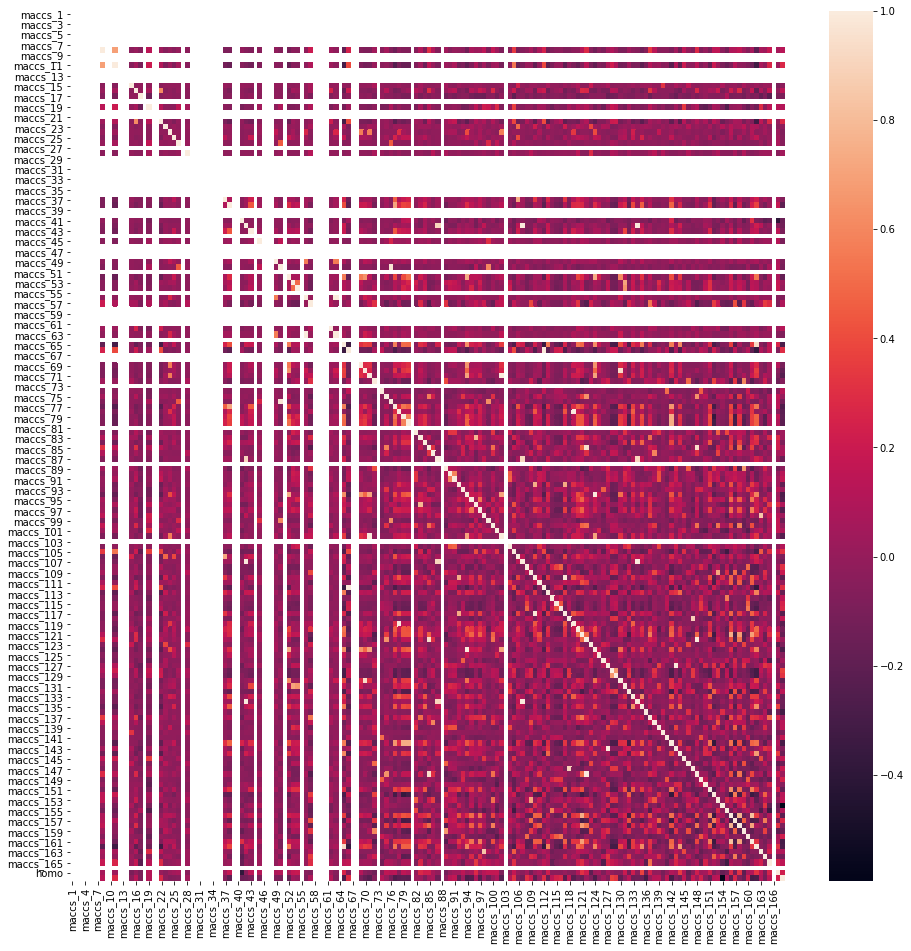

In [134]:
plt.figure(figsize = (16, 16))
sns.heatmap(data.corr())
plt.show()

## Apply model

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [170]:
def fit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    models = []
    models.append(('KRR', KernelRidge()))
    models.append(('Random forest', RandomForestRegressor()))
    models.append(('XGBoost', xgb.XGBRegressor()))
    
    results = []
    for name, clf in models:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results.append({
            'name': name, 
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        })
    
    return pd.DataFrame(results)

In [174]:
X = data.drop(['homo', 'lumo', 'atomization_e'], axis = 1)
y = data['lumo'] - data['homo']
fit(X, y)

,name,rmse,mae,r2
0,KRR,0.036057,0.027973,0.395694
1,Random forest,0.015758,0.010837,0.884579
2,XGBoost,0.015570,0.011109,0.887321


In [175]:
X = data.drop(['homo', 'lumo', 'atomization_e'], axis = 1)
y = data['atomization_e']
fit(X, y)

,name,rmse,mae,r2
0,KRR,177.299647,131.129453,0.524223
1,Random forest,118.058015,87.768618,0.789051
2,XGBoost,105.660086,77.416086,0.831030


In [178]:
data

,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,...,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,atomization_e,homo,lumo
smile,,,,,,,,,,,,,,,,,,,,,
OC1C2C3OC4C1N2C34,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,1,1,0,1569.140848,-0.2348,0.0213
N=C1N=CC=NC=N1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1228.659484,-0.2581,-0.1055
CC12CC3CC1C(=O)C23,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,1916.790874,-0.2313,-0.0027
NC1=NNC2=C1OC=N2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1337.413069,-0.2113,-0.0155
N#CC1NC1C1CC1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1570.864615,-0.2697,0.0167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCC1CCC2OC12,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,2170.328355,-0.2537,0.0884
CC1=CN=NO1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,0,971.264078,-0.2707,-0.0356
CC1N2CC(O)C12CO,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,1,1,0,1846.912099,-0.2365,0.0573
